# *MNIST with PyTorch Ignite by José Ananías Hilario Reyes*

## Introduction

In this notebook we will solve the image classification task for the `MNIST` dataset. However, the main idea is to use the task to showcase an engineering approach to deep learning pipelines using `PyTorch` and `Ignite` which aims to offer modularity: reusing functionalities across deep learning pipelines that have differences between each other but also a lot in common (e.g. image classification, image segmentation, GANs, self-supervised learning, etc.).

The learning curve of this approach is slightly steeper than vanilla scripting. Once the initial difficulties have been overcome, the convenience becomes evident. Libraries such as `FastAI` or `PyTorch Lightning` offer something similar, but the building blocks tend to be of a higher level of abstraction compared to `Ignite`, and this usually translates into complications when writing highly customized functionality.

## Install Conda package manager and required packages

This part of the notebook deals with creating a conda environment so that all packages requried can be installed at once.

This is a convenient approach so that we can quickly move from experimentation within the notebook to production-ready code: we control the versions and source channels of all the used packages in the same way in both environments.

This notebook was done originally for `Google Colab`; for `Jupyter` setting up the conda environment is more straightforward.

In [ ]:
!which python # should return /usr/local/bin/python
!python --version
!echo $PYTHONPATH

/usr/local/bin/python
Python 3.7.13
/env/python


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.11.0-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.anaconda.com/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
Unpacking payload ...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.10.26=h06a4308_2
    - certifi==2021.10.8=py37h06a4308_2
    - cffi==1.15.0=py37hd667e15_1
    - charset-normalizer==2.0.4=pyhd3eb1b0_0
    - conda-content-trust==0.1.1=pyhd3eb1b0_0
    - conda-package-handling==1.7.3=py37h27cfd23_1
    - conda==4.11.0=py37h06a4308_0
    - cryptography==36.0.0=py37h9ce1e76_0
    - idna==3.3=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4cf53a_17
    - ncurses==6.3=h7f8727e_2
    - openssl==1.1.1m=h7f8727e_0
    - pip==21.2.2=py37h06a4308_0
    - pycosat==0.6.3=py37h27cfd23_0
    - pycparser==2.21=pyhd3eb1b0_0
    - pyopenssl==21.0.0=py

--2022-04-03 07:27:18--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.11.0-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103730670 (99M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.11.0-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 59.6M 2s
    50K .......... .......... .......... .......... ..........  0% 10.9M 5s
   100K .......... .......... .......... .......... ..........  0% 34.4M 5s
   150K .......... .......... .......... .......... ..........  0% 46.7M 4s
   200K .......... .......... .......... .......... ..........  0% 49.6M 4s
   250K .......... .......... .......... .......... ..........  0% 50.6M 3s
   300K .......... .......... .......... .......... ..........  0% 50.0M 3s
   350K .......... .......... ......

In [ ]:
!which conda # should return /usr/local/bin/conda
!conda --version # should return 4.11.0
!which python # still returns /usr/local/bin/python
!python --version # now returns Python 3.7.11 :: Anaconda, Inc.

/usr/local/bin/conda
conda 4.11.0
/usr/local/bin/python
Python 3.7.11


In [ ]:
%%bash

conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.3.29  |       h06a4308_0         117 KB
    conda-4.12.0               |   py37h06a4308_0        14.5 MB
    openssl-1.1.1n             |       h7f8727e_0         2.5 MB
    ------------------------------------------------------------
                                           Total:        17.1 MB

The following packages will be UPDATED:

  ca-certificates                     2021.10.26-h06a4308_2 --> 2022.3.29-h06a4308_0
  conda                               4.11.0-py37h06a4308_0 --> 4.12.0-py37h06a4308_0
  openssl                                 1.1.1m-h7f8727e_0 --> 1.1.1n-h7f8727e_0



openssl-1.1.1n       | 2.5 MB    | ########## | 100% 
ca-certificates-2022 | 117

In [ ]:
import sys

_ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

In [ ]:
env = """
name: mnist-ignite
channels:
  - defaults
  - pytorch
  - conda-forge
dependencies:
  - captum~=0.4.0
  - dill~=0.3.4
  - einops~=0.3.0
  - ignite~=0.4.6
  - matplotlib~=3.4.3
  - mlflow~=1.19.0
  - numpy~=1.21.2
  - pandas~=1.3.3
  - pillow~=8.3.1
  - pip
  - python~=3.7.11
  - pytorch~=1.9.0
  - scikit-learn~=1.0.1
  - scipy~=1.7.1
  - seaborn~=0.11.2
  - torchserve~=0.4.2
  - torchvision~=0.10.0
  - pip:
    - mlflow-torchserve~=0.1.0
"""

In [ ]:
with open('environment.yml', 'w') as writefile:
    writefile.write(env)

In [ ]:
!conda env create -f environment.yml

In [ ]:
import sys

sys.path.append('/usr/local/envs/mnist-ignite/lib/python3.7/site-packages')

## Training

In [ ]:
import os
import sys
import time
import json
import math
import random
import signal
import logging
import argparse
import subprocess
from pathlib import Path
from copy import deepcopy
from typing import NamedTuple
from collections import defaultdict
from abc import ABC, abstractmethod

import torch
from torch import nn, optim
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms as t
from torchvision.datasets import MNIST
from ignite import distributed as idist
from ignite.engine import Engine, Events, EventEnum
from ignite.handlers.param_scheduler import LRScheduler
from ignite.metrics import RunningAverage, Loss, TopKCategoricalAccuracy
from PIL import Image, ImageOps, ImageFilter

##Utils

Here we have the logging functionality which is useful for debugging in production. It is being included in this task for the sake of completeness of the example pipeline.

In [ ]:
def get_logger(name, level=logging.INFO):
    logger = logging.getLogger(name)
    if logger.hasHandlers():
        logger.handlers.clear()
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    logger.setLevel(level)
    return logger

## Model

For a task such as image classification, there exist a family of models which rely on a well-tested (benchmark) architecture used as what is termed the backbone, which is the main part of the architecture. Then we connect this backbone to a classifier head, which in the simplest case is a linear layer.

Given this, we approach the model class in a generic way, where we write the functionality only once, and make the backbone itself the only part that needs to be changed in the children classes, according to the desired model to be used as backbone.

In [ ]:
class DownstreamBase(nn.Module, ABC):
    @classmethod
    @abstractmethod
    def get_backbone(cls):
        pass

    @staticmethod
    def _infer_features_backbone(backbone):
        in_features = None
        layers = reversed([module for module in backbone.modules() if not isinstance(module, nn.Sequential)])
        while in_features == None:
            layer = next(layers)
            if hasattr(layer, 'out_channels'):
                in_features = layer.out_channels
                break
            elif hasattr(layer, 'out_features'):
                in_features = layer.out_features
                break
        return in_features

    def __init__(self, channels, n):
        super().__init__()
        assert hasattr(self, 'get_backbone')
        self.backbone = self.get_backbone()
        assert hasattr(self.backbone, 'conv1')
        assert hasattr(self.backbone, 'fc')
        in_features = self.backbone.fc.in_features
        self.backbone.conv1 = nn.Conv2d(
            in_channels=channels,
            out_channels=self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=self.backbone.conv1.bias,
        )
        self.backbone.fc = nn.Identity()
        self.fc = nn.Linear(self._infer_features_backbone(self.backbone), n)
        self.fc.weight.data.normal_(mean=0.0, std=0.01)
        self.fc.bias.data.zero_()

    def forward(self, x):
        return self.fc(self.backbone(x))

class DownstreamResnet18(DownstreamBase):
    @classmethod
    def get_backbone(cls):
        return torch.hub.load(
            'pytorch/vision:v0.8.0', 'resnet18', pretrained=False
        )

    def __init__(self, channels=1, n=10):
        super().__init__(channels, n)

## Pipeline

The concept of a pipeline aims to solve the problem of code modularization for deep learning. The idea is to have a base pipeline which offers out-of-the-box functionality which can be leveraged for all kinds of different models (e.g. checkpointing, logging metrics, training and validation steps, etc.). Then there will be children of the base pipeline which will be base pipelines for a specific task (e.g. there could be a base pipeline for image classification tasks), and then any image classification pipeline that needs a bit of a different implementation can inherit from this and override the needed functionality.

In [ ]:
class EvaluatorEvents(EventEnum):
    VALIDATION_COMPLETED = 'validation_completed'

event_to_attr = {
    EvaluatorEvents.VALIDATION_COMPLETED: 'validation_completed'
}

class PipelineBase(ABC):
    logger = get_logger('PipelineBase', level=logging.INFO)

    @classmethod
    def log_train(cls, engine):
        _ = engine.state
        epoch = _.epoch
        step = _.iteration
        loss = _.metrics['loss']
        state = dict(epoch=epoch, step=step, loss=loss)
        cls.logger.debug(f'log_train - {json.dumps(state)}')

    @classmethod
    def persist_metrics(cls, engine, step, mode):
        assert step in {'epoch', 'iteration'}
        assert mode in {'train', 'validation'}
        for metric, value in engine.state.metrics.items():
            engine.state.progress[f'{mode}.{step}.{metric}'].append(value)
        cls.logger.debug(f'persist_metrics - {json.dumps(engine.state.metrics)}')

    @classmethod
    def save_checkpoint(cls, engine):
        _ = engine.state
        loss = engine.state.metrics['loss']
        try:
            state = dict(
                epoch=_.epoch, iteration=_.iteration, progress=dict(_.progress),
                model=_.model.module.state_dict(), optimizer=_.optimizer.state_dict(), loss=loss
            )
        except Exception as e:
            state = dict(
                epoch=_.epoch, iteration=_.iteration, progress=dict(_.progress),
                model=_.model.state_dict(), optimizer=_.optimizer.state_dict(), loss=loss
            )
        _.checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
        cls.logger.debug(f'save_checkpoint - {json.dumps(dict(epoch=_.epoch, iteration=_.iteration, loss=loss))}')
        torch.save(state, _.checkpoint_path)

    @classmethod
    def load_checkpoint(cls, engine):
        _ = engine.state
        if _.checkpoint_path.is_file():
            ckpt = torch.load(_.checkpoint_path, map_location='cpu')
            _.epoch = ckpt['epoch']
            _.iteration = ckpt['iteration']
            _.progress.update(ckpt['progress'])
            loss = ckpt['loss']
            try:
                _.model.module.load_state_dict(ckpt['model'])
            except Exception as e:
                _.model.load_state_dict(ckpt['model'])
            _.optimizer.load_state_dict(ckpt['optimizer'])
        else:
            _.epoch = 0
            _.iteration = 0
            loss = 0
        cls.logger.debug(f'load_checkpoint - {json.dumps(dict(epoch=_.epoch, iteration=_.iteration, loss=loss))}')


class Pipeline(PipelineBase):
    logger = get_logger('Pipeline', level=logging.INFO)

    @classmethod
    def train_step(cls, engine, batch):
        _ = engine.state
        x, y = batch
        x = x.to(_.device, non_blocking=True)
        y = y.to(_.device, non_blocking=True)
        y_pred = _.model(x)
        loss = _.criterion(y_pred, y)
        _.optimizer.zero_grad()
        loss.backward()
        _.optimizer.step()
        return dict(loss=loss)

    @classmethod
    def validation_step(cls, engine, batch):
        _ = engine.state
        _.model.eval()
        with torch.no_grad():
            x, target = batch[0].to(_.device, non_blocking=True), batch[1].to(_.device, non_blocking=True)
            y = _.model(x)
            return dict(y_pred=y, y=target, criterion_kwargs={})

    @classmethod
    def scheduler(cls, engine):
        _ = engine.state
        _.scheduler(engine)

    @classmethod
    def run_evaluator(cls, engine, evaluator, loader):
        evaluator.state.model = engine.state.model
        evaluator.run(loader)
        evaluator.state.validation_completed += 1
        evaluator.state.epoch = engine.state.epoch
        evaluator.fire_event(EvaluatorEvents.VALIDATION_COMPLETED)
        _ = evaluator.state
        top1, top5 = _.metrics['top1'], _.metrics['top5']
        _.best_acc.top1 = max(_.best_acc.top1, top1)
        _.best_acc.top5 = max(_.best_acc.top5, top5)
        cls.logger.debug(f'run_evaluator - {json.dumps(dict(best_top1=_.best_acc.top1, best_top5=_.best_acc.top5))}')

    @classmethod
    def get_dataflow(cls, args):
        if idist.get_local_rank() > 0:  # Only rank 0 will download the dataset
            idist.barrier()

        class Transform(object):
            def __init__(self, input_size=224, norm_mean=(0.1307,), norm_std=(0.3081,), mode='train'):
                self.transform = dict(
                    train=t.Compose([
                        t.RandomResizedCrop(input_size),
                        t.RandomHorizontalFlip(),
                        t.ToTensor(),
                        t.Normalize(mean=norm_mean, std=norm_std)
                    ]),
                    test=t.Compose([
                        t.Resize(int(256 / 224 * input_size)),
                        t.CenterCrop(input_size),
                        t.ToTensor(),
                        t.Normalize(mean=norm_mean, std=norm_std)
                    ])
                )[mode]
                self.mode = mode

            def __call__(self, x):
                return self.transform(x)

            def __repr__(self):
                return f'Transform(mode={self.mode}, transform={self.transform})'

        dataset = dict(
            train=MNIST('/tmp/MNIST/train', train=True, download=True, transform=Transform(mode='train')),
            test=MNIST('/tmp/MNIST/test', train=False, download=True, transform=Transform(mode='test')),
        )

        if idist.get_local_rank() == 0:  # Ensure that only local rank 0 download the dataset
            idist.barrier()

        kwargs = dict(batch_size=args.batch_size, num_workers=args.workers, pin_memory=True)
        loaders = {
            part: idist.auto_dataloader(dataset[part], shuffle=part == 'train', drop_last=part == 'train', **kwargs)
            for part in {'train', 'test'}
        }
        return loaders

    @classmethod
    def prepare_components(cls, engine):
        _ = engine.state
        torch.backends.cudnn.benchmark = True
        model = DownstreamResnet18(channels=1, n=10).to(_.device)
        assert hasattr(model, 'fc')
        classifier_parameters, model_parameters = [], []
        for name, param in model.named_parameters():
            if name in {'fc.weight', 'fc.bias'}:
                classifier_parameters.append(param)
            else:
                model_parameters.append(param)
        param_groups = [dict(params=classifier_parameters, lr=_.args.lr_classifier)]
        if _.args.weights == 'finetune':
            param_groups.append(dict(params=model_parameters, lr=_.args.lr_backbone))
        _.criterion = nn.CrossEntropyLoss().cuda(_.device)
        _.optimizer = optim.SGD(param_groups, 0, momentum=0.9, weight_decay=_.args.weight_decay)
        _.model = idist.auto_model(model)
        _.optimizer = idist.auto_optim(_.optimizer)
        _.scheduler = LRScheduler(optim.lr_scheduler.CosineAnnealingLR(_.optimizer, _.max_epochs))

    @classmethod
    def main_worker(cls, local_rank, args):
        cls.logger.setLevel(level=args.logging_level)
        args = args._replace(rank=idist.get_rank(), device=idist.device())

        trainer, evaluator = Engine(cls.train_step), Engine(cls.validation_step)
        loaders = cls.get_dataflow(args)
        train_loader, test_loader = loaders['train'], loaders['test']

        trainer_metrics = dict(loss=RunningAverage(output_transform=lambda out: out['loss']))
        for name, metric in trainer_metrics.items():
            metric.attach(trainer, name)

        evaluator.register_events(*EvaluatorEvents, event_to_attr=event_to_attr)
        evaluator_metrics = dict(
            loss=Loss(nn.CrossEntropyLoss()),
            top1=TopKCategoricalAccuracy(k=1),
            top5=TopKCategoricalAccuracy(k=5)
        )
        for name, metric in evaluator_metrics.items():
            metric.attach(evaluator, name)

        if args.rank == 0:
            trainer.on(Events.ITERATION_COMPLETED(every=args.print_freq))(cls.log_train)
            trainer.on(Events.EPOCH_COMPLETED)(cls.save_checkpoint)
            trainer.on(Events.EPOCH_COMPLETED, step='epoch', mode='train')(cls.persist_metrics)
            evaluator.on(EvaluatorEvents.VALIDATION_COMPLETED, step='epoch', mode='validation')(cls.persist_metrics)
        trainer.on(Events.STARTED)(cls.prepare_components)
        trainer.on(Events.STARTED)(cls.load_checkpoint)
        trainer.on(Events.EPOCH_COMPLETED)(cls.scheduler)
        trainer.on(Events.EPOCH_COMPLETED, evaluator, test_loader)(cls.run_evaluator)

        trainer_state = dict(
            epoch=0, max_epochs=args.epochs, epoch_length=len(train_loader), batch_size=args.batch_size,
            model=None, optimizer=None, criterion=None, scheduler=None, device=args.device, 
            progress=defaultdict(lambda: []), checkpoint_path=args.checkpoint_dir / 'model.pth', args=args
        )
        trainer._state_dict_user_keys = trainer_state.keys()
        trainer.load_state_dict(trainer_state)
        evaluator_state = {
            **trainer_state,
            **dict(
                max_epochs=1, epoch_length=len(test_loader), validation_completed=0,
                best_acc=argparse.Namespace(top1=0, top5=0)
            )
        }
        evaluator._state_dict_user_keys = evaluator_state.keys()
        evaluator.load_state_dict(evaluator_state)

        trainer.run(train_loader)
        return {**trainer.state.progress, **evaluator.state.progress}

Note below that the distributed execution of the pipeline is commented. On notebooks to this day (3.4.2022) problems persist in running distributed code on notebooks.

If this code is moved to a `Python` script, one should be capable of running it in the distributed setting with no changes other than uncommenting those two lines below, and commenting the last one below.

In [ ]:
class PipelineConfig(NamedTuple):
    backbone_args: NamedTuple = None
    rank: int = 0
    checkpoint_dir: Path = Path('/tmp/checkpoint8')
    device: torch.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    batch_size: int = max(torch.cuda.device_count(), 1)*128
    workers: int = max(torch.cuda.device_count()*2, 2)
    epochs: int = 30
    lr_backbone: float = 0.001
    lr_classifier: float = 0.001
    weight_decay: float = [1e-6, 0][0]
    weights: str = ['finetune', 'freeze'][0]
    num_classes: int = 10
    logging_level: int = logging.DEBUG
    print_freq: int = 64

spawn_kwargs = dict(
    nproc_per_node=4, nnodes=1, node_rank=0,
    master_addr='localhost', master_port=2223
)

# with idist.Parallel(backend='nccl', **spawn_kwargs) as parallel:
#     parallel.run(Pipeline.main_worker, PipelineConfig())

metrics = Pipeline.main_worker(0, PipelineConfig())

metrics

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/train/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/train/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/train/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/train/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/MNIST/test/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/MNIST/test/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/MNIST/test/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

2022-04-03 07:34:07,134 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset MNIST
    Nu': 
	{'shuffle': False, 'drop_last': False, 'batch_size': 128, 'num_workers': 2, 'pin_memory': True}
2022-04-03 07:34:07,138 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset 'Dataset MNIST
    Nu': 
	{'shuffle': True, 'drop_last': True, 'batch_size': 128, 'num_workers': 2, 'pin_memory': True}


Extracting /tmp/MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/MNIST/test/MNIST/raw



Downloading: "https://github.com/pytorch/vision/archive/v0.8.0.zip" to /root/.cache/torch/hub/v0.8.0.zip
2022-04-03 07:34:19,612 - Pipeline - DEBUG - load_checkpoint - {"epoch": 0, "iteration": 0, "loss": 0}
2022-04-03 07:35:07,446 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 64, "loss": 2.264565944671631}
2022-04-03 07:35:50,262 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 128, "loss": 2.183023691177368}
2022-04-03 07:36:33,023 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 192, "loss": 2.100374937057495}
2022-04-03 07:37:15,879 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 256, "loss": 2.02323842048645}
2022-04-03 07:37:58,785 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 320, "loss": 1.9806321859359741}
2022-04-03 07:38:41,555 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 384, "loss": 1.904845118522644}
2022-04-03 07:39:24,332 - Pipeline - DEBUG - log_train - {"epoch": 1, "step": 448, "loss": 1.8252488374710083}
2022-04-03 07:39:37,66

{'train.epoch.loss': [1.8044182062149048,
  1.1981290578842163,
  0.8757628202438354,
  0.7025234699249268,
  0.637345552444458,
  0.5546229481697083,
  0.5457772016525269,
  0.5074208378791809,
  0.4869803786277771,
  0.4562554955482483,
  0.44915589690208435,
  0.4333002269268036,
  0.41190657019615173,
  0.39938393235206604,
  0.4123433828353882,
  0.40930870175361633,
  0.4031069874763489,
  0.3760613799095154,
  0.37697356939315796,
  0.380104660987854,
  0.3767431080341339,
  0.356056809425354,
  0.3518719971179962,
  0.35840904712677,
  0.3624962270259857,
  0.347017765045166,
  0.35889679193496704,
  0.3386620283126831,
  0.35748639702796936,
  0.35114455223083496],
 'validation.epoch.loss': [1.50515361328125,
  0.532795654296875,
  0.263382861328125,
  0.1602712646484375,
  0.10511064453125,
  0.103855078125,
  0.1041179931640625,
  0.08637489013671874,
  0.07874031372070313,
  0.07373004760742187,
  0.06398050537109375,
  0.07564603881835938,
  0.05518651123046875,
  0.052648

In order to improve the results we would do hyperparameter search (e.g. with grid search or with a library such as `Bayesian Optimization Ax` from `Facebook`).

Also we can use other deep learning methods. For instance, self-supervised learning on images has been proven to give better results (note that self-supervised learning is done without labels; the result of this process is used as the initial weights for the training procedure, same as done above). Two state-of-the-art models that can be used for this are Barlow Twins and BYOL.

We would also need to set up the infrastructure for tracking experiments (models, hyperparameters, pipelines). For this we could use `MLflow`, which also has functionality for serving models (not only deep learning ones, but also general machine learning and other kinds of parametrized methods such as NMF or SVD).

For serving models for inference we could rely on `PyTorch` with `torchserve`. However, for a uniform approach to serving models we would rely on MLflow, which has a plugin integrating with `torchserve` for deep learning, and can deal also with the above-mentioned general parametrized methods as well.

For `MLOps` we would integrate the serving infrastructure with `Prometheus` and `Grafana` for monitoring. This could be useful for tracking data shift at serving time, and being able to determine when to relaunch training for the models being served in production. Another option is `Seldon`, which offers a solution specific to machine learning problems.

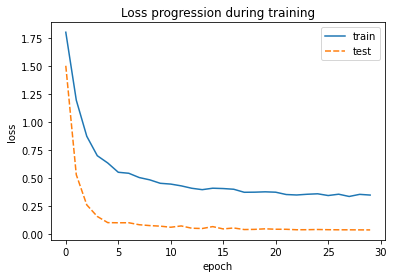

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

epochs = [i for i in range(len(metrics['train.epoch.loss']))]

ax = sns.lineplot(data=pd.DataFrame({'train': metrics['train.epoch.loss'], 'test': metrics['validation.epoch.loss']}, index=epochs))
ax.set_title('Loss progression during training')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

Note that the test loss is lower in our case than the train loss. This is due to the image augmentations we are using during training, which provide a regularizing effect which helps generalize the results to the out-of-sample error (i.e. the test error). We do not see yet that the test error shows signs of overfitting, which means we could continue training the model and hope to get a better result.

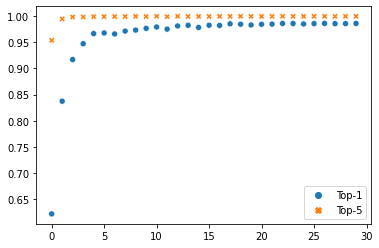

In [ ]:
sns.scatterplot(data=pd.DataFrame({'Top-1': metrics['validation.epoch.top1'], 'Top-5': metrics['validation.epoch.top5']}, index=epochs))
ax.set_title('Top-1 and Top-5 accuracy progression during training')
# Note: Top-k accuracy refers to the correct class being one of the top-k predicted classes
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

**As we can see from the previous cells, the best top-1 accuracy is 98.63%, while the best top-5 accuracy is 100%.**

Note that we focus on the best one because it is more indicative of the result we are able to get with this training setting.